# VehicleDetectionAndTracking_Prj5_V4

# Task List 

* 1 Perform a Histogram of Oriented Gradients (HOG) feature extraction
* 2 Normalize your features 
* 3 Randomize a selection for training and testing.
* 4 Train a classifier Linear SVM classifier
* 5 Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* 6 Run your pipeline on a video stream (create a heat map of recurring detections frame by frame to reject outliers       and follow detected vehicles and Estimate a bounding box for vehicles detected)

# Import 

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
%matplotlib inline
import os

from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.utils import shuffle 

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

# Support Functions 

In [2]:
def convert_color(image, color_space='RGB'):   
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        return np.copy(image)
    
    
def normalise(image):
    return (image - image.mean()) / (image.max() - image.min())


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img


def add_heat(heatmap, box_list):
    """Returns `heatmap` with bounding boxes in `box_list` added to it.
    This function should be applied per frame.
    """
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    """Returns heatmap with false positives removed."""
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    """Return image with bounding boxes drawn around the labelled regions.
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_bboxes(img, labels):
    """
    Universal bounding box painter, regardless of bBoxes format 
    :param img: image of interest
    :param bBoxes: list of bounding boxes.
    :param color: 
    :param thickness: 
    :return: 
    """
    color=(0, 255, 0)
    thickness=4
    for bBox in labels:
        bBox = np.array(bBox)
        bBox = bBox.reshape(bBox.size)
        cv2.rectangle(img=img, pt1=(bBox[0], bBox[1]), pt2=(bBox[2], bBox[3]), color=color, thickness=thickness)
        
    return img

# Image Features Functions

In [3]:
def bin_spatial(img, size=(64, 63)):#jaad
    # function to compute binned color features
    # create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

def color_hist(img, nbins=64, bins_range=(0, 256)):#jaad
    # Compute the histogram of the color channels separately
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))  
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # function to return HOG features and visualization
    
    #hog()
    #•Input: A single color channel or grayscaled image
    #•Parameters: 
    #◾orientations (int): ◦represents the number of orientation bins that the gradient 
    #  information will be split up into in the histogram. 
    #  Typical values are between 6 and 12 bins.

    #◾pixels_per_cell:◦specifies the cell size over which each gradient histogram is computed. 
    #  This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, 
    #  but cells are commonly chosen to be square.

    #◾cells_per_block:◦passed as a 2-tuple
    #  specifies the local area over which the histogram counts in a given cell will be normalized. 
    #  Block normalization is not necessarily required, but generally leads to a more robust feature set.

    if vis == True:
        features, hog_image = hog(img, 
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, 
                                  feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, 
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, 
                       feature_vector=feature_vec)
        return features
    
    
def single_img_features(img, 
                        color_space='RGB', 
                        spatial_size=(64, 64),#jaad
                        hist_bins=64, #jaad
                        orient=9, 
                        pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel=0,
                        spatial_feat=True, 
                        hist_feat=True, 
                        hog_feat=True,
                        vis = False
                       ):  
    
    # Define a function to extract features from a single image window
    img_features = []
    
    # Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)
  
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)    
        img_features.append(spatial_features)
        
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    # Compute HOG features if flag is set
    if hog_feat == True:
        
        if vis == False:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel],                                                          
                                    orient, pix_per_cell, cell_per_block, vis, feature_vec=True))      
            else:
                hog_features =          get_hog_features(feature_image[:,:,hog_channel], 
                                    orient, pix_per_cell, cell_per_block, vis, feature_vec=True)
            img_features.append(hog_features)
            return np.concatenate(img_features)
        
        else:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_feature , hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                               cell_per_block, vis, feature_vec=True)
                    hog_features.append(hog_feature)
                hog_features = np.ravel(hog_features)    
            else:
                hog_features , hog_image =  get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                                               cell_per_block, vis, feature_vec=True)
            
            img_features.append(hog_features)
            return np.concatenate(img_features) ,hog_image
        

        
def extract_features(files, 
                        color_space='RGB', 
                        spatial_size=(64, 64),#jaad
                        hist_bins=64, #jaad
                        orient=9, 
                        pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel=0,
                        spatial_feat=True, 
                        hist_feat=True, 
                        hog_feat=True,
                        vis = False
                       ): 
    
    features = [] 
    hog_images = [] 
    
    for file in files:
        img = mpimg.imread(file)
        if vis == False:
            file_feature = single_img_features(img, color_space, spatial_size, hist_bins, orient, pix_per_cell, 
                          cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, vis) 
            features.append(file_feature)
        else:
            file_feature, file_hogImage = single_img_features(img, color_space, spatial_size, hist_bins, orient, pix_per_cell, 
                          cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, vis) 
            features.append(file_feature)
            hog_images.append(file_hogImage)
            
    if vis == False:
        return features
    else:
        return features , hog_images  

# Image Augment Functions (For "Additonal" training data)

To develop powerful classifiers additional data will be created manipulating the incoming training data These 
augments are very specific to the objective of the neural network. (Copied from My Project 3)

In [4]:
def Augment_Brightness(image):
    #return: output image with adjusted brightness
        
    constant = 0.25
    #converted RGB image to HSV, scaled V (brightness) channel by a random number between .25 and 1.25, 
    #output is converted back to RGB
    #reason for adding constant is to avoid complete darkness. 
    
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb) #cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = constant+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1



def Augment_Shadow(image):
    #This is implemented by choosing random points and shading all points 
    #on one side (chosen randomly) of the image.
    
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]

    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

def Get_Augmented_Data(image):   

    image = Augment_Brightness(image)
    image = Augment_Shadow(image)   
   
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)   
    
    return image

# Sliding window search Functions

In [5]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5), polygon_mask=None):
    """Returns all windows to search in an image.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1

    # Initialize a list to append window positions to
    window_list = []

    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            if polygon_mask is not None:
                if polygon_mask[int(starty)][int(startx)] > 0:
                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
            else:
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(64, 64), hist_bins=64, #jaad
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Input image and the list of windows to be searched (output of slide_windows())

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    #print(on_windows)
    return on_windows

# Image Pipeline Function

In [6]:
def pipeline_image(image, x_start_stop, y_start_stop, xy_window_size, xy_overlap_size, mask, svc, X_scaler, color_space, 
                            
                  spatial_size, 
                  hist_bins,                             
                  orient, 
                  pix_per_cell, 
                  cell_per_block,                             
                  hog_channel,                             
                  spatial_feat,                             
                  hist_feat,                             
                  hog_feat,                            
                  bboxes_list=None,
                  draw = True
                 ):
        
    draw_image = np.copy(image)

    # Rescale .jpg (scaled 0 to 255) to 0 and 1 like training 
    image = image.astype(np.float32)/255    
   
    # Get list of windows to search at this stage.
    windows = slide_window(image, x_start_stop, y_start_stop, xy_window_size, xy_overlap_size, mask)

    # Return all the windows the classifier has predicted contain car(s) ('positive windows').
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space, 
                            spatial_size, hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat,hog_feat=hog_feat)         

    
    if(bboxes_list!=None):
        bboxes_list.append(hot_windows)
        
    if(draw == True):
        # Draw bounding boxes around the windows that the classifier predicted has cars in them
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
        return window_img
    

def colorHeatMap(heatMapMono, cmap=cv2.COLORMAP_HOT):
    """
    Makes an RGB version of the 1-channel heatMap
    :param heatMapMono: 
    :param cmap: The color map of choice
    :return: RGB heatMap
    """
    heatMapInt = cv2.equalizeHist(heatMapMono.astype(np.uint8))
    heatColor = cv2.applyColorMap(heatMapInt, cmap)
    heatColor = cv2.cvtColor(heatColor, code=cv2.COLOR_BGR2RGB)

    return heatColor

# Video Pipeline Function

In [7]:
def resize(src, ratio, interpolation=cv2.INTER_AREA):
    """
    Convenience wrapper for OpenCV resize function
    :param src: 
    :param ratio: 
    :param interpolation: 
    :return: 
    """
    return cv2.resize(src=src, dsize=(0, 0), fx=ratio, fy=ratio, interpolation=interpolation) 

def addPip(pipImage, dstImage, pipAlpha=0.5, pipResizeRatio=0.3, origin=(20, 20)):
    """
    Adding small Picture-in-picture binary bird-eye projection 
    :param pipImage: original binary bird-eye projection with search areas 
    :param dstImage: destination color image (assumed undistorted)
    :param pipAlpha: pip alpha
    :param pipResizeRatio: pip scale
    :param origin: coordinates of upper-left corner of small picture
    :return: color image with P-i-P embedded
    """
    smallPip = resize(src=pipImage, ratio=pipResizeRatio)

    pipHeight = smallPip.shape[0]
    pipWidth = smallPip.shape[1]

    backGround = dstImage[origin[1]:origin[1] + pipHeight, origin[0]:origin[0] + pipWidth]

    blend = np.round(backGround * (1 - pipAlpha), 0) + np.round(smallPip * pipAlpha, 0)

    blend = np.minimum(blend, 255)

    dstImage[origin[1]:origin[1] + pipHeight, origin[0]:origin[0] + pipWidth] = blend

    return dstImage

In [8]:
camMtx = None
distortionCoeffs = None
calibrationFile = 'calibration_data.p'
with open(calibrationFile, mode='rb') as f:
    data = pickle.load(f)
camMtx = data['cameraMatrix']
distortionCoeffs = data['distCoeffs']

def pipeline_video(image, bboxes_list, recent_frames_used=30, threshold=5): #20/5
    """`all_bboxes` is an array of arrays of bboxes.
    Each element represents a frame. Each element is an array of bboxes found in
    that frame."""
    
    image = cv2.undistort(image, camMtx, distortionCoeffs, None, camMtx)
    # Add bounding boxes from this frame
    pipeline_image(image, x_start_stop, y_start_stop, xy_window_size, xy_overlap_size,None,
                          svc, 
                          X_scaler, 
                          color_space, 
                          spatial_size, 
                          hist_bins,                            
                          orient, 
                          pix_per_cell, 
                          cell_per_block, 
                          hog_channel, 
                          spatial_feat, 
                          hist_feat, 
                          hog_feat,
                          bboxes_list,
                          False
                             )
   
    # Adjust parameters if needed
    if len(bboxes_list) < recent_frames_used + 1:
        recent_frames_used = len(bboxes_list) - 1    
    
    # Prepare heatmap template
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    # Construct heatmap
    for boxlist in bboxes_list[-recent_frames_used:]:
        frame_heatmap = add_heat(frame_heatmap, boxlist)
   
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    #frame_heatmap = np.clip(frame_heatmap, threshold,255)

    heatColor=colorHeatMap(frame_heatmap, cmap=cv2.COLORMAP_HOT)
    
    # Label regions
    labels = label(frame_heatmap)

    # Draw bounding boxes around labelled regions
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    pipAlpha = .7
    pipScaleRatio = .35
    origin=(20, 20)

    #addPip(pipImage, dstImage, pipAlpha=0.5, pipResizeRatio=0.3, origin=(20, 20))
    addPip(heatColor, draw_img, pipAlpha, pipScaleRatio,origin)
    
    #plt.imshow(draw_img)
    return draw_img

def process_image(image):
    global bboxes_list    
    
    return pipeline_video(image, bboxes_list)

# Parameters

In [9]:
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# Check that arrays are not empty
print("Car samples Count :",len(cars))
print("NotCar samples Count :",len(notcars))

cars2 = []
for index, item in enumerate(cars):
    cars2.append(Get_Augmented_Data(mpimg.imread(item)))

print("Additonal Car samples Count :",len(cars2))

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 5  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 3 #siraj 5 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 30 #64 #24    # Number of histogram bins #jaad
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
x_start_stop = [600, 1280]

Car samples Count : 8792
NotCar samples Count : 8984
Additonal Car samples Count : 8792


# Test Image Features Functions 

cars 42


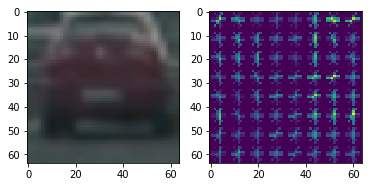

In [10]:
test_img = mpimg.imread(cars[42])
test_feature, test_hog_image  = single_img_features(test_img, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis = True)


plt.subplot(121)
plt.imshow(test_img)
plt.subplot(122)
plt.imshow(test_hog_image)   
print("cars 42")

HOG visualisation is a repr that shows the dominant gradient direction within each cell with brightness corresponding to the strength of gradients in that cell.

# Task 1 : Perform a Histogram of Oriented Gradients (HOG) feature extraction

In [11]:
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,vis = False)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat,vis=False)

# Task 2 : Normalize features 

In [12]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Normalise input
X = normalise(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Task 3: Randomize a selection for training and testing

In [13]:
from sklearn.utils import shuffle 
scaled_X, y = shuffle(scaled_X, y, random_state=42) # siraj 10-9-2017
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 5 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 5718


# Task 4 : Train a classifier Linear SVM classifier

In [14]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
start_time=time.time()
svc.fit(X_train, y_train)
end_time = time.time()
training_time = round(end_time-start_time, 4)

# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)


print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)
print("Feature vector length:" + str(len(X_train[0])))
print("Time to train SVC : " + str(training_time))
print("Test Accuracy of SVC : " + str(svc_score))


Parameters:
color_space:  YCrCb
orient:  5
pix_per_cell:  8
cell_per_block:  3
hog_channel:  ALL
spatial_size:  (16, 16)
hist_bins:  30
spatial_feat:  True
hist_feat:  True
hog_feat:  True
Feature vector length:5718
Time to train SVC : 20.6522
Test Accuracy of SVC : 0.98453318


# Task 5 : Test Image Pipeline 
(Sliding-window function and trained classifier to search for vehicles in a image)

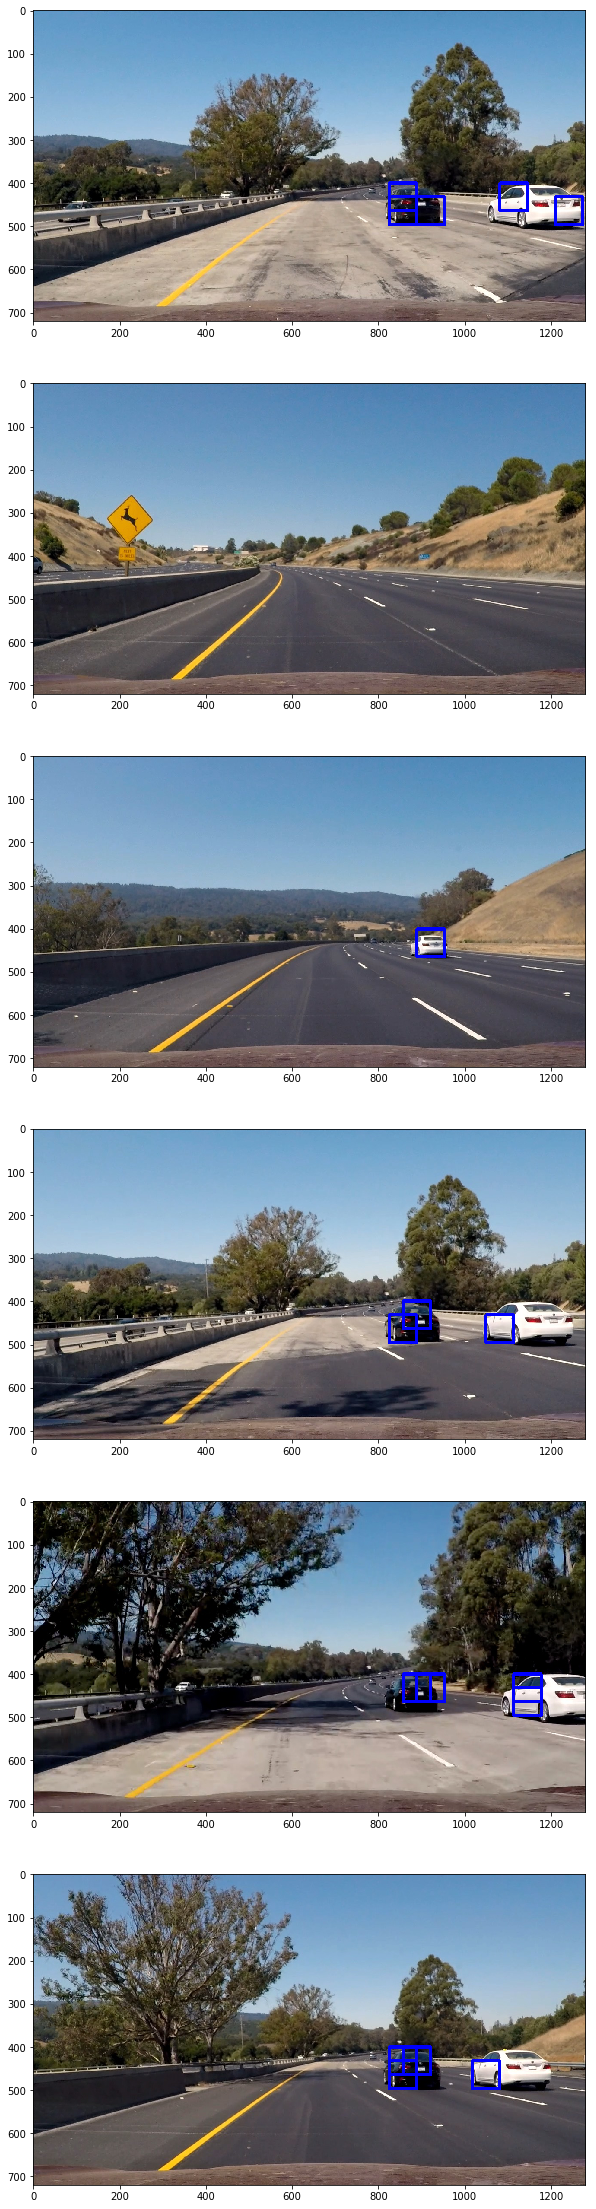

In [15]:
mpl_fig = plt.figure(figsize=(100,40))
mask = None
image1 = mpimg.imread('test_images/test1.jpg')
out_image1 = pipeline_image(image1, x_start_stop, y_start_stop, xy_window_size, xy_overlap_size,mask,
                          svc,X_scaler,color_space,spatial_size,hist_bins,orient,
                            pix_per_cell,cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat)
plt.subplot(611)
plt.imshow(out_image1)


image2 = mpimg.imread('test_images/test2.jpg')
out_image2 = pipeline_image(image2, x_start_stop, y_start_stop, xy_window_size, xy_overlap_size,mask,
                          svc,X_scaler,color_space,spatial_size,hist_bins,orient,
                            pix_per_cell,cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat)
plt.subplot(612)
plt.imshow(out_image2)

image3 = mpimg.imread('test_images/test3.jpg')
out_image3 = pipeline_image(image3, x_start_stop, y_start_stop, xy_window_size, xy_overlap_size,mask,
                          svc,X_scaler,color_space,spatial_size,hist_bins,orient,
                            pix_per_cell,cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat)
plt.subplot(613)
plt.imshow(out_image3)

image4 = mpimg.imread('test_images/test4.jpg')
out_image4 = pipeline_image(image4, x_start_stop, y_start_stop, xy_window_size, xy_overlap_size,mask,
                          svc,X_scaler,color_space,spatial_size,hist_bins,orient,
                            pix_per_cell,cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat)
plt.subplot(614)
plt.imshow(out_image4)

image5 = mpimg.imread('test_images/test5.jpg')
out_image5 = pipeline_image(image5, x_start_stop, y_start_stop, xy_window_size, xy_overlap_size,mask,
                          svc,X_scaler,color_space,spatial_size,hist_bins,orient,
                            pix_per_cell,cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat)
plt.subplot(615)
plt.imshow(out_image5)

image6 = mpimg.imread('test_images/test6.jpg')
out_image6 = pipeline_image(image6, x_start_stop, y_start_stop, xy_window_size, xy_overlap_size,mask,
                          svc,X_scaler,color_space,spatial_size,hist_bins,orient,
                            pix_per_cell,cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat)

plt.subplot(616)
plt.imshow(out_image6)


dir = "output_images"
try:
    os.stat(dir)
except:
    os.mkdir(dir)   

output_file_name = os.path.join('output_images/test1.jpg')
mpimg.imsave(output_file_name,out_image1)

output_file_name = os.path.join('output_images/test2.jpg')
mpimg.imsave(output_file_name,out_image2)

output_file_name = os.path.join('output_images/test3.jpg')
mpimg.imsave(output_file_name,out_image3)

output_file_name = os.path.join('output_images/test4.jpg')
mpimg.imsave(output_file_name,out_image4)

output_file_name = os.path.join('output_images/test5.jpg')
mpimg.imsave(output_file_name,out_image5)

output_file_name = os.path.join('output_images/test6.jpg')
mpimg.imsave(output_file_name,out_image6)

# Task 6 : Test video pipeline on a video stream

In [16]:
bboxes_list = []

video = VideoFileClip("project_video.mp4")#.subclip(5,15)
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "output_v5.mp4"
%time project_clip.write_videofile(video_output, audio=False)

print("Bounding boxes: ", len(bboxes_list))

[MoviePy] >>>> Building video output_v5.mp4
[MoviePy] Writing video output_v5.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:35<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_v5.mp4 

Wall time: 19min 36s
Bounding boxes:  1261


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [18]:
bboxes_list = []

video = VideoFileClip("test_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "output_2_v5.mp4"
%time project_clip.write_videofile(video_output, audio=False)

print("Bounding boxes: ", len(bboxes_list))

[MoviePy] >>>> Building video output_2_v5.mp4
[MoviePy] Writing video output_2_v5.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:35<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_2_v5.mp4 

Wall time: 36.5 s
Bounding boxes:  39


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))